In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from tqdm import tqdm_notebook as tqdm
from tcn import TCN
import time
from sklearn.metrics import mean_squared_error, r2_score
from keras.preprocessing import sequence
from keras.models import Sequential , load_model , Model
from keras.layers import Dense, Dropout , LSTM , Bidirectional ,GRU ,Flatten,Add,BatchNormalization
from keras_layer_normalization import LayerNormalization
from keras.initializers import  glorot_normal, RandomUniform
from keras import optimizers,Input
from keras_self_attention import SeqSelfAttention
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Using TensorFlow backend.


In [2]:
df = pd.read_csv("london_merged.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.set_index("timestamp")
#df.head()

df["hour"] = df.index.hour
df["day_of_month"] = df.index.day
df["day_of_week"]  = df.index.dayofweek
df["month"] = df.index.month

training_data_len = math.ceil(len(df) * 0.9) # taking 90% of data to train and 10% of data to test
testing_data_len = len(df) - training_data_len

time_steps = 24
train, test = df.iloc[0:training_data_len], df.iloc[(training_data_len-time_steps):len(df)]
print(df.shape, train.shape, test.shape)

(17414, 13) (15673, 13) (1765, 13)


In [3]:
train_trans = train[['t1','t2', 'hum', 'wind_speed']].to_numpy()
test_trans = test[['t1','t2', 'hum', 'wind_speed']].to_numpy()

scaler = RobustScaler() # Handles outliers
#scaler = MinMaxScaler(feature_range=(0, 1)) # scale to (0,1)
train.loc[:, ['t1','t2','hum', 'wind_speed']]=scaler.fit_transform(train_trans)
test.loc[:, ['t1','t2', 'hum', 'wind_speed']]=scaler.fit_transform(test_trans)

train['cnt'] = scaler.fit_transform(train[['cnt']])
test['cnt'] = scaler.fit_transform(test[['cnt']])

C:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

In [4]:
#Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in tqdm(range(len(train) - time_steps)):
    x_train.append(train.drop(columns='cnt').iloc[i:i + time_steps].to_numpy())
    y_train.append(train.loc[:,'cnt'].iloc[i + time_steps])

#Convert x_train and y_train to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

#Create the x_test and y_test data sets
x_test = []
y_test = df.loc[:,'cnt'].iloc[training_data_len:len(df)]

for i in tqdm(range(len(test) - time_steps)):
    x_test.append(test.drop(columns='cnt').iloc[i:i + time_steps].to_numpy())
    # y_test.append(test.loc[:,'cnt'].iloc[i + time_steps])

#Convert x_test and y_test to numpy arrays
x_test = np.array(x_test)
y_test = np.array(y_test)

# All 12 columns of the data
print('Train size:')
print(x_train.shape, y_train.shape)
print('Test size:')
print(x_test.shape, y_test.shape)

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/15649 [00:00<?, ?it/s]

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1741 [00:00<?, ?it/s]

Train size:
(15649, 24, 12) (15649,)
Test size:
(1741, 24, 12) (1741,)


In [ ]:
# define Network Block

In [70]:
from keras.layers import Concatenate
init = glorot_normal(seed=None) # 給 GRU
init_d = RandomUniform(minval=-0.05, maxval=0.05) # 給 Dense layer

def Encoder(layer):
    shortcut = layer
    layer = SeqSelfAttention(
                     attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
                     kernel_regularizer=tf.keras.regularizers.l2(0.01),
                     bias_regularizer=tf.keras.regularizers.l2(0.01),
                     attention_regularizer_weight=0.0001)(layer)
    layer = Add()([layer,shortcut])
    layer = LayerNormalization()(layer)
    layer = Flatten()(layer)
    
    shortcut2 = layer
    layer = Dense(32,kernel_initializer=init_d)(layer)
    layer = Dropout(0.2)(layer)
    layer = Concatenate()([layer,shortcut2])
    output = Dense(1,kernel_initializer=init_d)(layer)
    return output

def Decoder(layer):
    shortcut = layer
    layer = SeqSelfAttention(
                     attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
                     kernel_regularizer=tf.keras.regularizers.l2(0.01),
                     bias_regularizer=tf.keras.regularizers.l2(0.01),
                     attention_regularizer_weight=0.0001)(layer)
    layer = Add()([layer,shortcut])
    layer = LayerNormalization()(layer)
    layer = SeqSelfAttention(
                     attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
                     kernel_regularizer=tf.keras.regularizers.l2(0.01),
                     bias_regularizer=tf.keras.regularizers.l2(0.01),
                     attention_regularizer_weight=0.0001)(layer)
    layer = LayerNormalization()(layer)
    
    layer = Flatten()(layer)
    shortcut2 = layer
    layer = Dense(32,kernel_initializer=init_d)(layer)
    layer = Dropout(0.2)(layer)
    layer = Concatenate()([layer,shortcut2])
    output = Dense(1,kernel_initializer=init_d)(layer)
    return output

def Bi_GRU(layer,unit):
    output = Bidirectional(GRU(unit, dropout=0.1, recurrent_dropout=0.1, return_sequences=True,
                            kernel_initializer=init))(layer)
    return output


# def tcn(layer):
#     layer = TCN(#input_shape=(x_train.shape[1],x_train.shape[2]),
#                  kernel_size=3,
#                  nb_filters=80,
#                  nb_stacks=1,
#                  dilations=(1, 2, 4, 8, 16),
#                  kernel_initializer='glorot_uniform',
#                  use_skip_connections=True,
#                  use_batch_norm=False,
#                  use_weight_norm=False,
#                  use_layer_norm=True,
#                  dropout_rate = 0.05,
#                  return_sequences=True)(layer)
#     layer = Dropout(0.2)(layer)
#     output = Dense(1)(layer)
#     return output
    

In [ ]:
# Build Network

In [71]:
#start = Input(shape = (x_train.shape[1],x_train.shape[2]))
start = Input(shape = (x_train.shape[1:]))
start2 = Input(shape = (x_train.shape[1:]))
x = Bi_GRU(start,64)
x = Encoder(x)

y = Bi_GRU(start2,32)
y = Decoder(y)

Merge = Add()([x,y])
# Merge = Add()([x,x])
Last = Dense(1)(Merge)
model = Model([start,start2] , Last)
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           (None, 24, 12)       0                                            
__________________________________________________________________________________________________
bidirectional_26 (Bidirectional (None, 24, 64)       8640        input_35[0][0]                   
__________________________________________________________________________________________________
input_34 (InputLayer)           (None, 24, 12)       0                                            
__________________________________________________________________________________________________
seq_self_attention_27 (SeqSelfA (None, 24, 64)       4097        bidirectional_26[0][0]           
___________________________________________________________________________________________

In [72]:
print('Train...')
model.compile(optimizer = "adam" , loss="mse")
history = model.fit([x_train,x_train], y_train, epochs = 120, batch_size=24, validation_split=0.1, shuffle=True)
model.summary()
#Save Model
model.save('GRU_Single_Attention_model_block.h5')  # creates a HDF5 file 
del model

Train...
Train on 14084 samples, validate on 1565 samples
Epoch 1/120
14084/14084 [==============================] - 46s 3ms/step - loss: 1.9629 - val_loss: 0.6605
Epoch 2/120
14084/14084 [==============================] - 45s 3ms/step - loss: 0.4235 - val_loss: 0.2444
Epoch 3/120
14084/14084 [==============================] - 44s 3ms/step - loss: 0.2025 - val_loss: 0.1592
Epoch 4/120
14084/14084 [==============================] - 45s 3ms/step - loss: 0.1558 - val_loss: 0.1118
Epoch 5/120
14084/14084 [==============================] - 44s 3ms/step - loss: 0.1487 - val_loss: 0.1603
Epoch 6/120
14084/14084 [==============================] - 45s 3ms/step - loss: 0.1270 - val_loss: 0.0879
Epoch 7/120
14084/14084 [==============================] - 44s 3ms/step - loss: 0.1140 - val_loss: 0.1371
Epoch 8/120
14084/14084 [==============================] - 44s 3ms/step - loss: 0.1065 - val_loss: 0.1115
Epoch 9/120
14084/14084 [==============================] - 44s 3ms/step - loss: 0.0923 - val_l

14084/14084 [==============================] - 44s 3ms/step - loss: 0.0434 - val_loss: 0.0846
Epoch 78/120
14084/14084 [==============================] - 45s 3ms/step - loss: 0.0422 - val_loss: 0.0672
Epoch 79/120
14084/14084 [==============================] - 45s 3ms/step - loss: 0.0421 - val_loss: 0.1021
Epoch 80/120
14084/14084 [==============================] - 44s 3ms/step - loss: 0.0425 - val_loss: 0.0711
Epoch 81/120
14084/14084 [==============================] - 44s 3ms/step - loss: 0.0427 - val_loss: 0.0735
Epoch 82/120
14084/14084 [==============================] - 44s 3ms/step - loss: 0.0437 - val_loss: 0.0694
Epoch 83/120
14084/14084 [==============================] - 44s 3ms/step - loss: 0.0425 - val_loss: 0.0801
Epoch 84/120
14084/14084 [==============================] - 44s 3ms/step - loss: 0.0404 - val_loss: 0.0839
Epoch 85/120
14084/14084 [==============================] - 44s 3ms/step - loss: 0.0409 - val_loss: 0.0776
Epoch 86/120
14084/14084 [========================

In [73]:
custom_ob = {'LayerNormalization': LayerNormalization , 'SeqSelfAttention':SeqSelfAttention,'TCN':TCN}
model = load_model('GRU_Single_Attention_model_block.h5', custom_objects=custom_ob)
t1 = time.time()
y_pred = model.predict([x_test,x_test])
t2 = time.time()
print('Predict time: ',t2-t1)
y_pred = scaler.inverse_transform(y_pred)#Undo scaling

Predict time:  1.2029619216918945


RMSE:  348.3202524400943
R-square:  0.8594749589420626
Adj R-square:  0.8594749589420626


Text(0, 0.5, 'mse score')

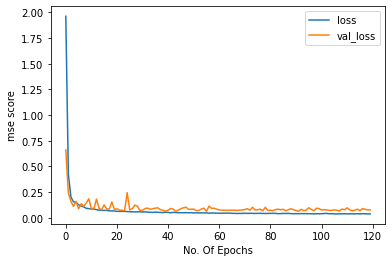

In [74]:
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE: ',rmse_lstm)

r2 =  r2_score(y_test, y_pred)
print('R-square: ',r2)

n = len(y_test)
p = 12
Adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('Adj R-square: ',r2)

plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="val_loss")
plt.legend(loc="best")
plt.xlabel("No. Of Epochs")
plt.ylabel("mse score")

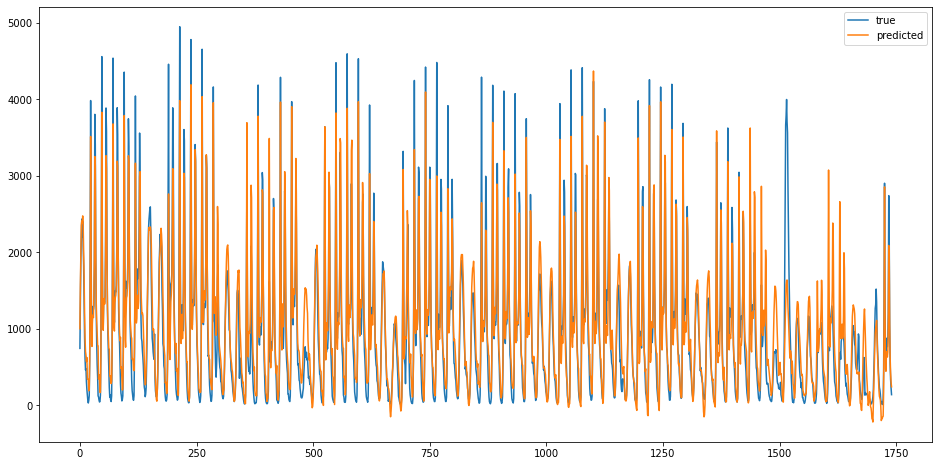

In [75]:
plt.figure(figsize=(16, 8))
plt.plot(y_test, label='true')
plt.plot(y_pred, label='predicted')
plt.legend()

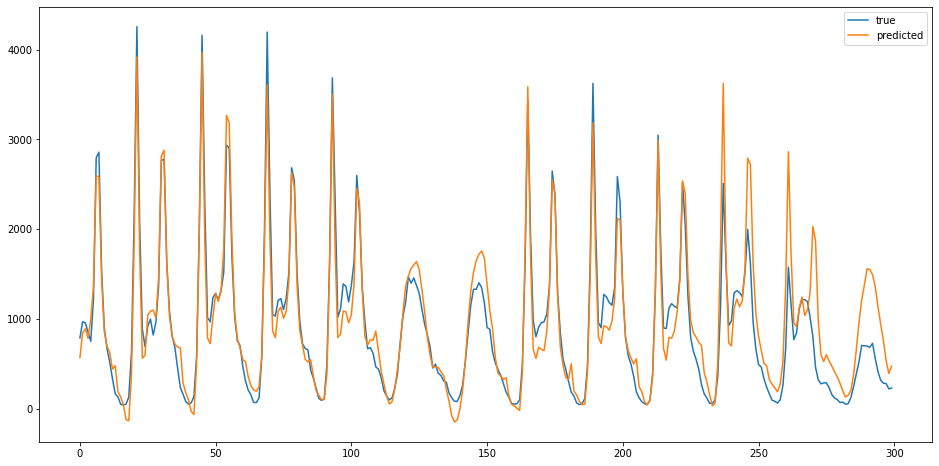

In [76]:
plt.figure(figsize=(16, 8))
plt.plot(y_test[1200:1500], label='true')
plt.plot(y_pred[1200:1500], label='predicted')
plt.legend()